## Text-Based Ad Feedback Topic Modeling: Preprocessing & Training

### TOC
* [Step 1: Load Data & Packages](#1)
* [Step 2: Tokenize & Remove Stopwords](#2)
* [Step 3: Lemmatization](#3)
* [Step 4: Create Dataframes for Modeling](#4)
* [Step 5: Term Frequency Analysis](#5)
* [Step 6: Train-Test Split](#6)
* [Step 7: Save Processed Data](#7)

### Step 1: Load Data & Packages<a class="anchor" id="1"></a>

In [1]:
#Import Packages
import numpy as np 
import pandas as pd
import qgrid
def view(df_test):
    return qgrid.show_grid(df_test, grid_options={'forceFitColumns': False, 'defaultColumnWidth': 100})
import spacy
import en_core_web_sm
from spacy.tokenizer import Tokenizer
import gensim
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
import matplotlib.pyplot as plt
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
#Open data
clean_df = pd.read_csv('../Datafiles/Feedback_df_clean.csv')

In [3]:
#Explore data again
clean_df.head()

,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean
0,R_eS4NGrnSGSYTxSh,A little informative,DF,Likes,18,White Only,5,1,0,1,a little informative
1,R_31EnmC82PmXgfeJ,A lot of chemicals are in vapes that damage th...,DF,Main Message,17,White Only,1,1,0,1,a lot of chemicals are in vapes that damage th...
2,R_xniZkHbwJjrCac1,a lot of information all at once,DF,Dislikes,17,White Only,5,1,0,0,a lot of information all at once
3,R_2UVKzhgLoqvkyzk,A method of discouragement against vaping by i...,DD,Main Message,18,White Only,4,0,0,0,a method of discouragement against vaping by i...
4,R_2PC3MSRmAF3ln2c,About the ingredients in vape,ST,Main Message,18,White Only,1,1,1,0,about the ingredients in vape


### Step 2: Tokenize & Remove Stopwords<a class="anchor" id="2"></a>
Source: Code adapted from a Towards Data Science article posted by Amin Azad at https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2, retrieved in January 2021.

In [4]:
#Load Spacy Stopwords

# Load spacy
nlp = en_core_web_sm.load()

#Stop words from spacy
STOP_WORDS = nlp.Defaults.stop_words

#### Running Tokenizer: 
* Excluding 'nothing','none','everything', and'anything' from stop words list
* Decided to keep vape in and allow TF-IDF to filter out as part of model parameters

In [5]:
# Tokenizer - Excluding 'none','nothing', and 'not'
tokenizer = Tokenizer(nlp.vocab)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)

#Remove these from stop words
ALL_STOP_WORDS.difference_update(['nothing','none','everything','anything'])

tokens = []

for doc in tokenizer.pipe(clean_df['Text_Clean'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in ALL_STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
clean_df['Tokens'] = tokens

In [6]:
#Sort to see if any data was lost
clean_df = clean_df.sort_values(by='Tokens')

#Review results -- use tail because first few will be blank
clean_df.tail()

,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens
4334,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,Main Message,18,White Only,1,0,1,0,young people should not be addicted to vapes,"[young, people, addicted, vapes]"
354,R_2q9Kw3MpcWPSx2Z,"Even as a young person, you can be more succep...",DF,Main Message,18,Black Only,4,1,1,0,even as a young person you can be more succep...,"[young, person, , succeptible, infectious, di..."
4335,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,Main Message,18,White Only,5,0,0,1,younger people need to stop being fooled comp...,"[younger, people, need, stop, fooled, , compa..."
1135,R_73QU3qjaCTJbNTP,It can make youth feel targeted and cornered,ST,Dislikes,18,White Only,5,1,1,1,it can make youth feel targeted and cornered,"[youth, feel, targeted, cornered]"
749,R_2uvXUWNU8uZWOXD,I like how it zoomed in on the facts and then ...,DD,Likes,17,White Only,5,1,0,1,i like how it zoomed in on the facts and then ...,"[zoomed, facts, zoomed, switch, fact]"


### Step 3: Lemmatization <a class="anchor" id="3"></a>
For consistency, will use Spacy lemmatization.<br>

In [7]:
#Make tokens a string again
clean_df['Tokens_String'] = [' '.join(map(str, l)) for l in clean_df['Tokens']]

#Some tokens are just spaces now because of the remove of stopwords, so need to remove extra spaces
strings = [" ".join(i.split()) for i in clean_df['Tokens_String']]
    
#Update 'Tokens_String' to new list of strings without extra spaces
clean_df['Tokens_String'] = strings

Source: Spacy Lemmatization Code adapted from a Towards Data Science article posted by Amin Azad at https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2, retrieved in January 2021.

In [8]:
#Lemmatize
def get_lemmas(text):
    '''Used to lemmatize the processed tokens'''    
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return lemmas

clean_df['Lemma_Tokens'] = clean_df['Tokens_String'].apply(get_lemmas)

In [9]:
#Review results -- use tail because first few will be blank
clean_df.tail()

,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Tokens_String,Lemma_Tokens
4334,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,Main Message,18,White Only,1,0,1,0,young people should not be addicted to vapes,"[young, people, addicted, vapes]",young people addicted vapes,"[young, people, addicted, vape]"
354,R_2q9Kw3MpcWPSx2Z,"Even as a young person, you can be more succep...",DF,Main Message,18,Black Only,4,1,1,0,even as a young person you can be more succep...,"[young, person, , succeptible, infectious, di...",young person succeptible infectious diseases s...,"[young, person, succeptible, infectious, disea..."
4335,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,Main Message,18,White Only,5,0,0,1,younger people need to stop being fooled comp...,"[younger, people, need, stop, fooled, , compa...",younger people need stop fooled companies targ...,"[young, people, need, stop, fool, company, tar..."
1135,R_73QU3qjaCTJbNTP,It can make youth feel targeted and cornered,ST,Dislikes,18,White Only,5,1,1,1,it can make youth feel targeted and cornered,"[youth, feel, targeted, cornered]",youth feel targeted cornered,"[youth, feel, target, cornered]"
749,R_2uvXUWNU8uZWOXD,I like how it zoomed in on the facts and then ...,DD,Likes,17,White Only,5,1,0,1,i like how it zoomed in on the facts and then ...,"[zoomed, facts, zoomed, switch, fact]",zoomed facts zoomed switch fact,"[zoom, fact, zoom, switch, fact]"


In [10]:
# Make lemmas a string again
clean_df['Lemmas_String'] = [' '.join(map(str, l)) for l in clean_df['Lemma_Tokens']]

#Delete 'Tokens_String' because we will be using 'Lemmas_String' moving forward
clean_df = clean_df.drop(columns = ['Tokens_String'])

In [11]:
#Review results -- use tail because first few will be blank
clean_df.tail()

,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
4334,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,Main Message,18,White Only,1,0,1,0,young people should not be addicted to vapes,"[young, people, addicted, vapes]","[young, people, addicted, vape]",young people addicted vape
354,R_2q9Kw3MpcWPSx2Z,"Even as a young person, you can be more succep...",DF,Main Message,18,Black Only,4,1,1,0,even as a young person you can be more succep...,"[young, person, , succeptible, infectious, di...","[young, person, succeptible, infectious, disea...",young person succeptible infectious disease sm...
4335,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,Main Message,18,White Only,5,0,0,1,younger people need to stop being fooled comp...,"[younger, people, need, stop, fooled, , compa...","[young, people, need, stop, fool, company, tar...",young people need stop fool company target you...
1135,R_73QU3qjaCTJbNTP,It can make youth feel targeted and cornered,ST,Dislikes,18,White Only,5,1,1,1,it can make youth feel targeted and cornered,"[youth, feel, targeted, cornered]","[youth, feel, target, cornered]",youth feel target cornered
749,R_2uvXUWNU8uZWOXD,I like how it zoomed in on the facts and then ...,DD,Likes,17,White Only,5,1,0,1,i like how it zoomed in on the facts and then ...,"[zoomed, facts, zoomed, switch, fact]","[zoom, fact, zoom, switch, fact]",zoom fact zoom switch fact


### Step 4: Create Dataframes for Modeling <a class="anchor" id="4"></a>

In [12]:
#Remove blanks from sample and create new 'processed_df' for modeling
clean_df['Lemmas_String'] = clean_df['Lemmas_String'].str.strip()
processed_df = clean_df[clean_df['Lemmas_String']!=""]

In [13]:
#Now that the df is filtered, reset index as well
processed_df = processed_df.reset_index().drop(columns='index').copy()

In [14]:
#Review results
print('\033[1m' + 'clean_df Shape'+'\033[0m')
print(clean_df.shape)
print('\033[1m' + 'processed_df Shape'+'\033[0m')
print(processed_df.shape)
print('\033[1m' + 'View processed_df'+'\033[0m')
processed_df.head()

clean_df Shape
(4338, 14)
processed_df Shape
(4285, 14)
View processed_df


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
0,R_31EnmC82PmXgfeJ,"Again, the animation was cool. The colours cau...",DF,Likes,17,White Only,1,1,0,1,again the animation was cool the colours cau...,"[ , animation, cool, , colours, caught, atten...","[animation, cool, colour, catch, attention, vi...",animation cool colour catch attention visual c...
1,R_239pmeEO6hI1ruk,it just didnt seem serious. like the boy didnt...,DF,Dislikes,17,Two or More - Non Hispanic,3,0,1,0,it just did not seem serious like the boy did...,"[ , boy, actually, sick]","[boy, actually, sick]",boy actually sick
2,R_1ojAU8BtuIQW0RX,"No, I clearly understand the advertisement it ...",DF,Dislikes,13,Hispanic/Latino ANY,5,1,1,0,no i clearly understand the advertisement it ...,"[ , clearly, understand, advertisement, straig...","[clearly, understand, advertisement, straight,...",clearly understand advertisement straight forw...
3,R_1ml7bY9vXgKe5Cl,"All of it, especially the animations",DF,Likes,16,White Only,5,0,1,1,all of it especially the animations,"[ , especially, animations]","[especially, animation]",especially animation
4,R_33kcqvtUqNrjini,i like that it “exposes” the truth,ST,Likes,16,Hispanic/Latino ANY,3,0,1,0,i like that it exposes the truth,"[ , exposes, , truth]","[expose, truth]",expose truth


#### Split processed df into Questions for modeling

In [15]:
message_df = processed_df[processed_df['Question']=='Main Message'].copy()
message_df = message_df.reset_index().drop(columns='index').copy()
print("\033[1m"+'Messages DF Values:'+"\033[0;0m")
print(message_df['Question'].value_counts())

likes_df = processed_df[processed_df['Question']=='Likes'].copy()
likes_df = likes_df.reset_index().drop(columns='index').copy()
print("\033[1m"+'Likes DF Values:'+"\033[0;0m")
print(likes_df['Question'].value_counts())

dislikes_df = processed_df[processed_df['Question']=='Dislikes'].copy()
dislikes_df = dislikes_df.reset_index().drop(columns='index').copy()
print("\033[1m"+'Dislikes DF Values:'+"\033[0;0m")
print(dislikes_df['Question'].value_counts())

Messages DF Values:
Main Message    1443
Name: Question, dtype: int64
Likes DF Values:
Likes    1426
Name: Question, dtype: int64
Dislikes DF Values:
Dislikes    1416
Name: Question, dtype: int64


### Step 5: Check Term Frequency Again <a class="anchor" id="5"></a>

#### Main Message Feedback Text Frequency

Source: Term Frequency Analysis and WordCloud code adapted from Towards Data Science article by Kamil Mysiak at 
https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d retrieved in January, 2021.

In [16]:
#Create word list
words = message_df['Lemma_Tokens']
allwords = []
for wordlist in words:
    allwords += wordlist

In [17]:
#Create function for word frequency bar plots
color_palette = ['midnightblue','#24478f','steelblue','#7FB3D5','skyblue','#b3e0ff'] 
def word_bar(x,y,figsize,colors):
    #Loop below creates the percentage labels
    y_percents = []
    for i in y:
        y_percents.append((round((i / (np.sum(y))) *100,1)))
    
    y_perlabs = []
    for i in y_percents: 
        y_perlabs.append(str(i)+'%')
    y_perlabs = np.array(y_perlabs)
    
    x = x
    
    plt.subplots(figsize=figsize)
    plt.bar(x, y, align='center', color=colors) #actual bar plot setup
    plt.xticks(rotation=60)


    # Text on the top of each bar, 
    # Code for below adapted from https://www.python-graph-gallery.com/10-barplot-with-number-of-observation
    for i in range(len(x)):
        plt.text(x = x[i] , y = y[i]+0.5, s=y_perlabs[i])

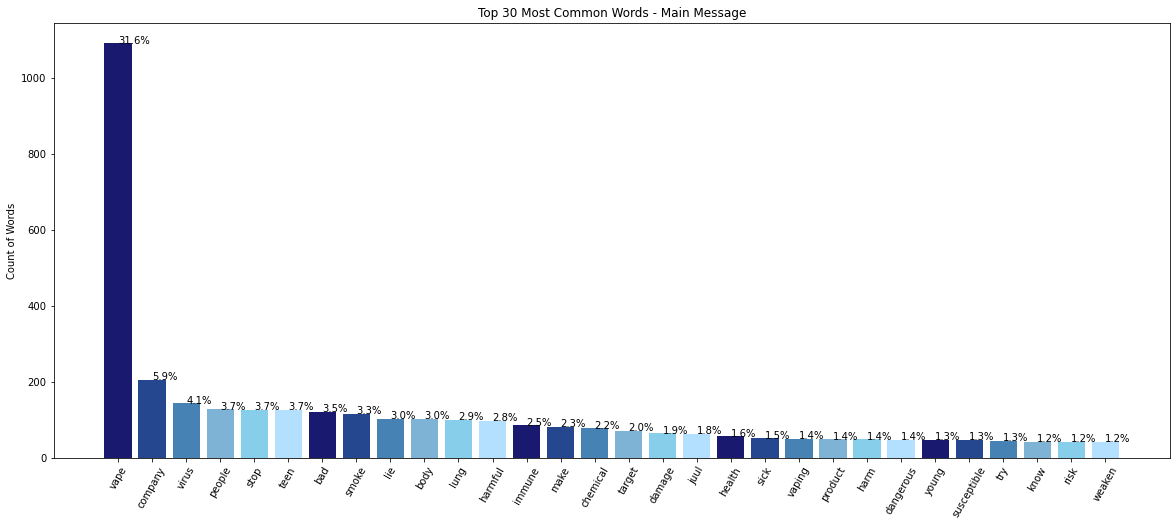

In [18]:
mostcommon_small = FreqDist(allwords).most_common(30)
x, y = zip(*mostcommon_small)
        
word_bar(x,y,(20,8),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Top 30 Most Common Words - Main Message')
plt.ylabel('Count of Words')
plt.show()

#### Likes Feedback Text Frequency

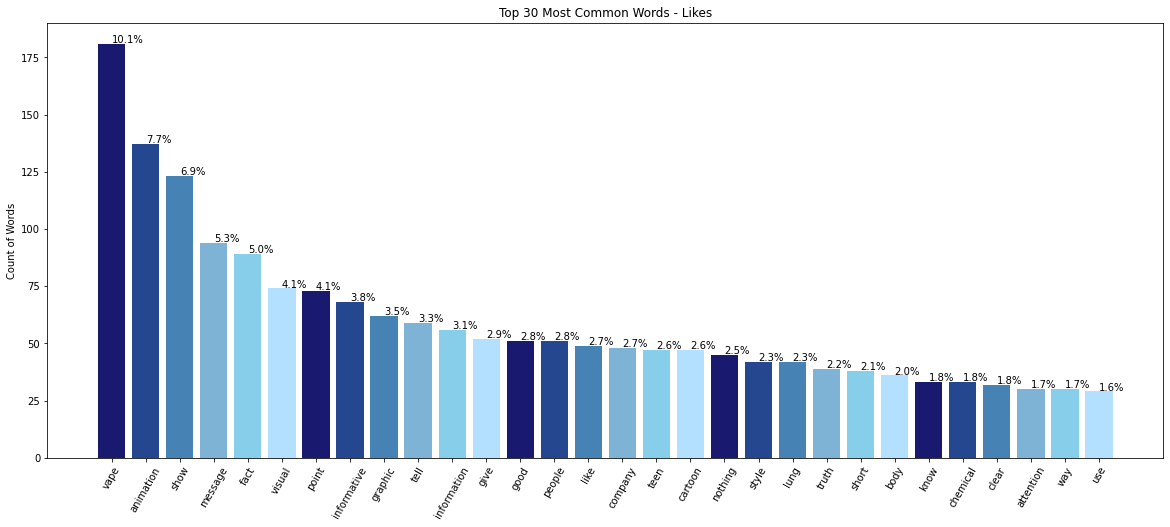

In [19]:
#Create word list
words = likes_df['Lemma_Tokens']
allwords = []
for wordlist in words:
    allwords += wordlist
    
mostcommon_small = FreqDist(allwords).most_common(30)
x, y = zip(*mostcommon_small)
        
word_bar(x,y,(20,8),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Top 30 Most Common Words - Likes')
plt.ylabel('Count of Words')
plt.show()

#### Dislikes Feedback Text Frequency

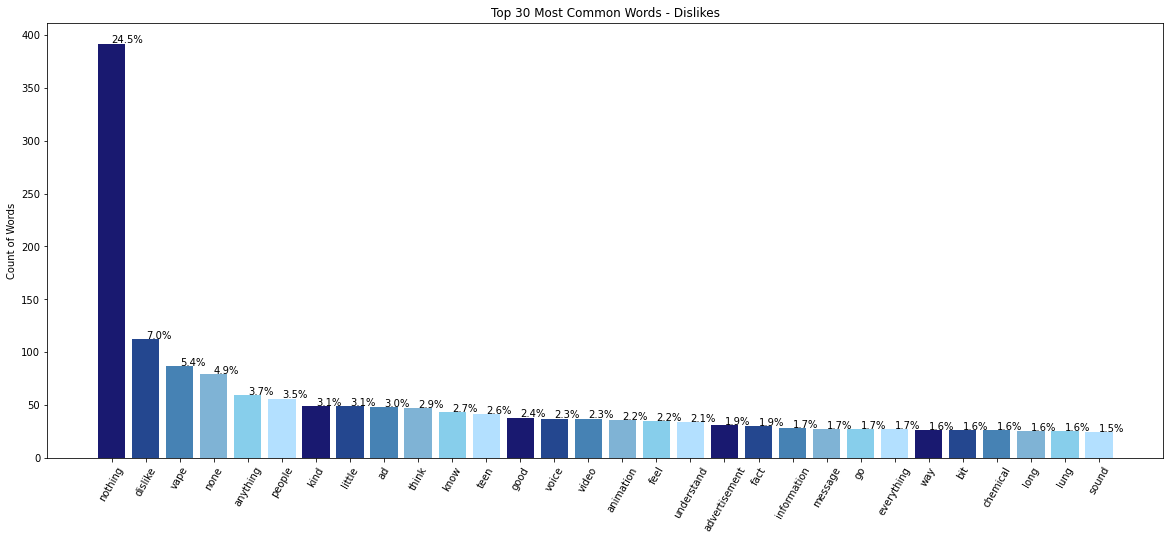

In [20]:
#Create word list
words = dislikes_df['Lemma_Tokens']
allwords = []
for wordlist in words:
    allwords += wordlist
    
mostcommon_small = FreqDist(allwords).most_common(30)
x, y = zip(*mostcommon_small)
        
word_bar(x,y,(20,8),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Top 30 Most Common Words - Dislikes')
plt.ylabel('Count of Words')
plt.show()

#### Notes:
* Top words across questions are clean and ready for splitting
* Words like 'vape', 'dislike', 'like', 'nothing' may be filtered out of topics when word vectors are created. In order to avoid optimizing unseen data, decided not to filter manually prior to splitting.

### Step 6: Train-Test Split<a class="anchor" id="6"></a> 
Typically splitting the data into training & test sets is not necessary for unsupervised learning. However, because hyper-parameter tuning will be needed for topic modeling, it is best to split the data so that 'unseen' data is not used in optimization.

#### Message df

In [21]:
#View ad distribution to see if stratification is needed

print("\033[1m"+'Number of Cases in Message df:'+"\033[0;0m")
print(message_df.shape[0])
print("\033[1m"+'Percentage\n'+"\033[0;0m"+str(round(message_df['Ad'].value_counts(normalize=True),2)*100))

Number of Cases in Message df:
1443
Percentage
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


#### Notes: 
* Text feedback is not balanced across ads, so need to stratify the train-test split by ad in order to ensure the train and test data reflect a similar distribution of ads.

In [22]:
#Conduct train test split (just with X because this is unsupervised) and stratify by ad
#Using 70% train, 30% test to ensure about 1000 training cases
#Using index in order to create full train and test dfs

X_train, X_test = train_test_split(message_df.index, stratify=message_df['Ad'], test_size=0.3, random_state=22)

In [23]:
#Create the training df for message
message_train = message_df.iloc[X_train]
#Create the test df for message
message_test = message_df.iloc[X_test]

In [24]:
#Check work
print("\033[1m"+'Training df for Message n:'+"\033[0;0m")
print(message_train.shape[0])
print("\033[1m"+'Training df for Message Ad Distribution:'+"\033[0;0m")
print(str(round(message_train['Ad'].value_counts(normalize=True),2)*100))
message_train.head()

Training df for Message n:
1010
Training df for Message Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
1164,R_31uv8ZYxWzGA5mX,How vaping is dangerous,DF,Main Message,13,White Only,5,1,0,1,how vaping is dangerous,"[vaping, dangerous]","[vape, dangerous]",vape dangerous
80,R_OKkt2YwXKW2ncpb,That these companies are lying and trying to g...,DD,Main Message,17,White Only,1,0,1,1,that these companies are lying and trying to g...,"[companies, lying, trying, young, people, addi...","[company, lie, try, young, people, addicted, p...",company lie try young people addicted profit
971,R_3JfRSXh8wuxjmVD,Vapes break down your lungs immunity on a cell...,DF,Main Message,18,White Only,5,0,1,0,vapes break down your lungs immunity on a cell...,"[vapes, break, lungs, immunity, cellular, level]","[vape, break, lung, immunity, cellular, level]",vape break lung immunity cellular level
1208,R_1NgKMwWIcOdlLmm,To show that vaping is harmful.,DF,Main Message,16,Two or More - Non Hispanic,1,1,0,0,to show that vaping is harmful,"[vaping, harmful]","[vape, harmful]",vape harmful
1298,R_3P4WD4pJ8ds0U8y,Vaping makes you more likely to get viruses so...,DF,Main Message,16,White Only,4,1,1,0,vaping makes you more likely to get viruses so...,"[vaping, makes, likely, viruses, vale]","[vaping, make, likely, virus, vale]",vaping make likely virus vale


In [25]:
#Check work
print("\033[1m"+'Test df for Message n:'+"\033[0;0m")
print(message_test.shape[0])
print("\033[1m"+'Test df for Message Ad Distribution:'+"\033[0;0m")
print(str(round(message_test['Ad'].value_counts(normalize=True),2)*100))
message_test.head()

Test df for Message n:
433
Test df for Message Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
1068,R_Y38cefIjMPeUowh,Vaping is bad for you and it isn’t harmless li...,ST,Main Message,17,White Only,1,1,1,1,vaping is bad for you and it is not harmless l...,"[vaping, bad, harmless, people]","[vape, bad, harmless, people]",vape bad harmless people
1258,R_BuqBemXY9khzd29,Vaping will kill you,ST,Main Message,16,White Only,5,1,1,0,vaping will kill you,"[vaping, kill]","[vape, kill]",vape kill
1322,R_phG75xdJLVvPuz7,Vaping makes you more vulnerable,DF,Main Message,18,White Only,1,1,1,1,vaping makes you more vulnerable,"[vaping, makes, vulnerable]","[vape, make, vulnerable]",vape make vulnerable
761,R_10u6vwGSw6XIyNV,You shouldn’t vape,DF,Main Message,15,White Only,4,1,0,1,you should not vape,[vape],[vape],vape
683,R_TvaQpZJYyk4FC7L,The truths behind what vape companies put out,DD,Main Message,13,Black Only,1,1,1,0,the truths behind what vape companies put out,"[truths, vape, companies]","[truth, vape, company]",truth vape company


#### Likes df

In [26]:
#View ad distribution to see if stratification is needed

print("\033[1m"+'Number of Cases in Likes df:'+"\033[0;0m")
print(likes_df.shape[0])
print("\033[1m"+'Percentage\n'+"\033[0;0m"+str(round(likes_df['Ad'].value_counts(normalize=True),2)*100))

Number of Cases in Likes df:
1426
Percentage
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


In [27]:
#Conduct train test split (just with X because this is unsupervised) and stratify by ad
#Using 70% train, 30% test to ensure about 1000 training cases
#Using index in order to create full train and test dfs

X_train, X_test = train_test_split(likes_df.index, stratify=likes_df['Ad'], test_size=0.3, random_state=22)

In [28]:
#Create the training df for likes
likes_train = likes_df.iloc[X_train]
#Create the test df for likes
likes_test = likes_df.iloc[X_test]

In [29]:
#Check work
print("\033[1m"+'Training df for Likes n:'+"\033[0;0m")
print(likes_train.shape[0])
print("\033[1m"+'Training df for Likes Ad Distribution:'+"\033[0;0m")
print(str(round(likes_train['Ad'].value_counts(normalize=True),2)*100))
likes_train.head()

Training df for Likes n:
998
Training df for Likes Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
529,R_22qTlo0r3xnZyTw,Grabbed my attention,DD,Likes,17,Black Only,5,1,0,1,grabbed my attention,"[grabbed, attention]","[grab, attention]",grab attention
804,R_ThmJI9fLSKCxVNn,Message,DF,Likes,18,White Only,4,1,1,1,message,[message],[message],message
689,R_2wTz8O4kTvM57R9,Interesting articles and the voice is relatable.,DD,Likes,17,White Only,6,1,0,1,interesting articles and the voice is relatable,"[interesting, articles, voice, relatable]","[interesting, article, voice, relatable]",interesting article voice relatable
885,R_1fjiNCL1NCK36nM,Nothing really,DD,Likes,16,White Only,1,1,1,0,nothing really,[nothing],[nothing],nothing
1,R_1ml7bY9vXgKe5Cl,"All of it, especially the animations",DF,Likes,16,White Only,5,0,1,1,all of it especially the animations,"[ , especially, animations]","[especially, animation]",especially animation


In [30]:
#Check work
print("\033[1m"+'Test df for Likes n:'+"\033[0;0m")
print(likes_test.shape[0])
print("\033[1m"+'Test df for Likes Ad Distribution:'+"\033[0;0m")
print(str(round(likes_test['Ad'].value_counts(normalize=True),2)*100))
likes_test.head()

Test df for Likes n:
428
Test df for Likes Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
1047,R_3Pvtjv7uIGuw5OB,I like how short it is and the animation,DF,Likes,17,White Only,5,1,1,1,i like how short it is and the animation,"[short, animation]","[short, animation]",short animation
190,R_ugDBhFyLUDZPBoB,The cartoon,DF,Likes,18,White Only,4,1,1,0,the cartoon,[cartoon],[cartoon],cartoon
1225,R_3I0LOCb0msiQsMH,i like the strong visuals with the lungs,DF,Likes,17,White Only,6,1,1,0,i like the strong visuals with the lungs,"[strong, visuals, lungs]","[strong, visual, lung]",strong visual lung
172,R_u7Kpx3eaQ2N8MWl,They bring out specific evidence,DD,Likes,18,Black Only,5,1,1,0,they bring out specific evidence,"[bring, specific, evidence]","[bring, specific, evidence]",bring specific evidence
902,R_2aqSlXyutx0DY3g,Nothing,DF,Likes,17,White Only,5,0,0,1,nothing,[nothing],[nothing],nothing


#### Dislikes df

In [31]:
#View ad distribution to see if stratification is needed

print("\033[1m"+'Number of Cases in Dislikes df:'+"\033[0;0m")
print(dislikes_df.shape[0])
print("\033[1m"+'Percentage\n'+"\033[0;0m"+str(round(dislikes_df['Ad'].value_counts(normalize=True),2)*100))

Number of Cases in Dislikes df:
1416
Percentage
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


In [32]:
#Conduct train test split (just with X because this is unsupervised) and stratify by ad
#Using 70% train, 30% test to ensure about 1000 training cases
#Using index in order to create full train and test dfs

X_train, X_test = train_test_split(dislikes_df.index, stratify=dislikes_df['Ad'], test_size=0.3, random_state=22)

In [33]:
#Create the training df for dislikes
dislikes_train = dislikes_df.iloc[X_train]
#Create the test df for dislikes
dislikes_test = dislikes_df.iloc[X_test]

In [34]:
#Check work
print("\033[1m"+'Training df for Dislikes n:'+"\033[0;0m")
print(dislikes_train.shape[0])
print("\033[1m"+'Training df for Dislikes Ad Distribution:'+"\033[0;0m")
print(str(round(dislikes_train['Ad'].value_counts(normalize=True),2)*100))
dislikes_train.head()

Training df for Dislikes n:
991
Training df for Dislikes Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
920,R_1l06ObyQvljPXKR,nothing,DF,Dislikes,17,White Only,4,1,1,1,nothing,[nothing],[nothing],nothing
1282,R_1Cmw8Ydsx3716fR,i can’t really think about it,DD,Dislikes,15,White Only,5,1,1,1,i can not really think about it,[think],[think],think
1017,R_AGQvCqSOgtym7Lz,Nothing,DD,Dislikes,18,Black Only,5,1,1,1,nothing,[nothing],[nothing],nothing
193,R_3DnzdbM8b8LzvDw,I also dont have any complaints,DD,Dislikes,17,White Only,3,1,1,0,i also do not have any complaints,[complaints],[complaint],complaint
1151,R_3O999dm00L0d1z1,I did not like how they didn’t provide specifi...,DD,Dislikes,18,White Only,4,1,1,1,i did not like how they did not provide specif...,"[provide, specific, examples]","[provide, specific, example]",provide specific example


In [35]:
#Check work
print("\033[1m"+'Test df for Dislikes n:'+"\033[0;0m")
print(dislikes_test.shape[0])
print("\033[1m"+'Test df for Dislikes Ad Distribution:'+"\033[0;0m")
print(str(round(dislikes_test['Ad'].value_counts(normalize=True),2)*100))
dislikes_test.head()

Test df for Dislikes n:
425
Test df for Dislikes Ad Distribution:
DF    50.0
ST    26.0
DD    24.0
Name: Ad, dtype: float64


,ID,Text_Original,Ad,Question,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Tokens,Lemma_Tokens,Lemmas_String
1026,R_1o73JBZ6DHXIiF7,nothing,DF,Dislikes,18,White Only,1,1,0,1,nothing,[nothing],[nothing],nothing
182,R_26avwl8d6fZ2iUA,colors,DF,Dislikes,16,Black Only,3,1,1,0,colors,[colors],[color],color
1257,R_qELxRVl8Tn9buAF,I suppose I disliked that the video said I sho...,DD,Dislikes,15,White Only,4,1,0,1,i suppose i disliked that the video said i sho...,"[suppose, disliked, video, said, know, vape, c...","[suppose, disliked, video, say, know, vape, co...",suppose disliked video say know vape company g...
1323,R_1MTFg4oXbN9Y4eJ,That it is trying to get me to quit,DF,Dislikes,16,White Only,5,0,0,1,that it is trying to get me to quit,"[trying, quit]","[try, quit]",try quit
260,R_D6odTAWD37pRWCd,I don’t dislike anything,DF,Dislikes,18,White Only,2,1,1,1,i do not dislike anything,"[dislike, anything]","[dislike, anything]",dislike anything


### Step 7: Save Processed Data<a class="anchor" id="7"></a> 

In [36]:
#Save message train to CSV.
message_train.to_csv('../Datafiles/message_train.csv', index=False)

#Save message test to CSV.
message_test.to_csv('../Datafiles/message_test.csv', index=False)

#Save likes train to CSV.
likes_train.to_csv('../Datafiles/likes_train.csv', index=False)

#Save likes test to CSV.
likes_test.to_csv('../Datafiles/likes_test.csv', index=False)

#Save dislikes train to CSV.
dislikes_train.to_csv('../Datafiles/dislikes_train.csv', index=False)

#Save dislikes test to CSV.
dislikes_test.to_csv('../Datafiles/dislikes_test.csv', index=False) 